## Essencial Functions and Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import average_precision_score



## Read data

In [3]:
from pathlib import Path
import numpy as np
import tifffile as tiff
from difflib import get_close_matches

# Main dataset directory
dataset_dir = Path('spotlite_dataset_loca1_date1_dir1')

images_dir = dataset_dir / 'images'
masks_dir = dataset_dir / 'masks'

assert images_dir.exists(), f"Image folder not found: {images_dir}"
assert masks_dir.exists(), f"Mask folder not found: {masks_dir}"

# Collect all image and mask files (multiple extensions)
image_paths = sorted(
    [*images_dir.glob('*.tif'), *images_dir.glob('*.tiff')],
    key=lambda p: p.stem
)
mask_paths = sorted(
    [*masks_dir.glob('*.tif'), *masks_dir.glob('*.tiff'),
     *masks_dir.glob('*.png'), *masks_dir.glob('*.jpg')],
    key=lambda p: p.stem
)

# Dictionary of masks by base name
mask_dict = {p.stem: p for p in mask_paths}
unused_masks = set(mask_dict.keys())

imgs_array, masks_array = [], []

for img_path in image_paths:
    stem = img_path.stem
    mask_path = None

    # 1) Exact match
    if stem in mask_dict:
        mask_path = mask_dict[stem]
        unused_masks.discard(stem)
    else:
        # 2) Approximate match
        candidates = get_close_matches(stem, mask_dict.keys(), n=1, cutoff=0.6)
        if candidates:
            sel = candidates[0]
            mask_path = mask_dict[sel]
            unused_masks.discard(sel)
        else:
            # 3) No match found; just notify and skip
            print(f"Warning: no mask found for {img_path.name}; skipping.")
            continue

    # Read image and mask
    img = tiff.imread(str(img_path))
    msk = tiff.imread(str(mask_path))

    # Check dimensions
    if img.shape[:2] != msk.shape:
        raise ValueError(
            f"Incompatible dimensions: {img_path.name} {img.shape[:2]} vs "
            f"{mask_path.name} {msk.shape}"
        )

    imgs_array.append(img)
    masks_array.append(msk)

# Remaining masks
if unused_masks:
    print("Warning: these masks were not used (no corresponding image):")
    for s in sorted(unused_masks):
        print("  ", s)

# Stack arrays
imgs = np.stack(imgs_array, axis=0)   # (N, H, W, C)
masks = np.stack(masks_array, axis=0)  # (N, H, W)

print(f'Final: {len(imgs)} pairs loaded.')
print(f'Shape of imgs: {imgs.shape}')
print(f'Shape of masks: {masks.shape}')


Final: 191 pairs loaded.
Shape of imgs: (191, 512, 512, 4)
Shape of masks: (191, 512, 512)


## Convert labels in masks

In [4]:
# Convert labels in masks from 0, 3, 4 to 0, 1, 2
# where 0 is background, 1 is class 1, and 2 is class
def remap_mask(mask):
    if not torch.is_tensor(mask):
        mask = torch.from_numpy(mask)
    remapped = torch.zeros_like(mask)
    remapped[mask == 0] = 0
    remapped[mask == 3] = 1
    remapped[mask == 4] = 2
    return remapped.long()

masks = remap_mask(masks)

print(f'shape of remapped masks: {masks.shape}')

shape of remapped masks: torch.Size([191, 512, 512])


## Extract features and labels

In [5]:
N, H, W, C = imgs.shape
X = imgs.reshape(-1, C)       # shape = (N*H*W, 4)
y = masks.reshape(-1)         # shape = (N*H*W,)

print(f'shape of X: {X.shape}')
print(f'shape of y: {y.shape}')

# (Opcional) amostragem para acelerar treino
# idx = np.random.choice(len(y), size=100000, replace=False)
# X, y = X[idx], y[idx]

shape of X: (50069504, 4)
shape of y: torch.Size([50069504])


## Check Inbalance

Classe 0: 48,043,641 pixels (95.95%)
Classe 1: 687,567 pixels (1.37%)
Classe 2: 1,338,296 pixels (2.67%)
   class    counts    percent
0      0  48043641  95.953898
1      1    687567   1.373225
2      2   1338296   2.672876


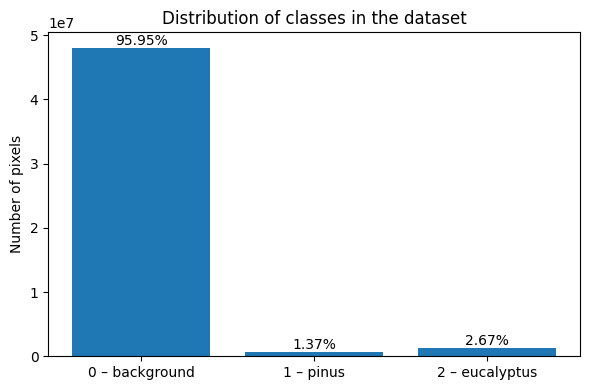

In [6]:
y = np.array(y)

y_flat = y.reshape(-1)
total_pixels = y_flat.size
classes, counts = np.unique(y_flat, return_counts=True)

for cls, ct in zip(classes, counts):
    pct = ct / total_pixels * 100
    print(f"Classe {cls}: {ct:,} pixels ({pct:.2f}%)")

df_dist = pd.DataFrame({
    "class":   classes,
    "counts":  counts,
    "percent": counts / total_pixels * 100
})
print(df_dist)

class_names = {
    0: "background",
    1: "pinus",
    2: "eucalyptus"
}
x_labels = [f"{cls} – {class_names[cls]}" for cls in df_dist['class']]

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(df_dist['class'], df_dist['counts'])

ax.set_ylabel('Number of pixels')
ax.set_title('Distribution of classes in the dataset')

ax.set_xticks(df_dist['class'])
ax.set_xticklabels(x_labels)

for bar, pct in zip(bars, df_dist['percent']):
    x  = bar.get_x() + bar.get_width()/2
    y  = bar.get_height()
    ax.text(x, y, f"{pct:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Analise the Features

In [26]:
import plotly.express as px
import numpy as np
import pandas as pd

# NDVI = (NIR - R) / (NIR + R)
# [R, G, B] → check classic visual coupling

# [G, NIR, NDVI] → check if NDVI helps separate vegetation
# [NDVI, GNDVI, NIR] → check separation by indices
# [H, S, V] or [L, A, B] if converted to HSV or LAB

R = X[:, 0]
G = X[:, 1]
B = X[:, 2]
NIR = X[:, 3]

NDVI = (NIR - R) / (NIR + R + 1e-5)
GNDVI = (NIR - G) / (NIR + G + 1e-5)

def plot_3d_features(X, y, feature_names=None, title="3D Distribution of Classes", max_samples=10000, random_state=42, html_path="interactive_plot.html"):

    # Stratified sampling
    np.random.seed(random_state)
    sampled_X = []
    sampled_y = []

    for cls in np.unique(y):
        mask = (y == cls)
        X_cls = X[mask]
        y_cls = y[mask]
        n = min(max_samples // 3, len(X_cls))
        idx = np.random.choice(len(X_cls), size=n, replace=False)
        sampled_X.append(X_cls[idx])
        sampled_y.append(y_cls[idx])

    X_vis = np.vstack(sampled_X)
    y_vis = np.hstack(sampled_y)

    # Feature names
    if feature_names is None:
        feature_names = ["Feature 1", "Feature 2", "Feature 3"]

    # Create DataFrame
    df = pd.DataFrame(X_vis, columns=feature_names)
    df["class"] = y_vis
    df["class"] = df["class"].map({0: "Background", 1: "Pine", 2: "Eucalyptus"})

    # Plot with Plotly
    fig = px.scatter_3d(
        df, x=feature_names[0], y=feature_names[1], z=feature_names[2],
        color="class", opacity=0.5, title=title, size_max=5
    )
    fig.update_traces(marker=dict(size=2))

    # Save as HTML
    fig.write_html(html_path)
    print(f"✅ Interactive plot saved at: {html_path}")
    print("📂 You can download this file or open it directly in your browser.")


### RGB Space

In [ ]:
X_vis = np.stack([R, G, B], axis=1)
plot_3d_features(X_vis, y, feature_names=["R", "G", "B"], max_samples=10000, html_path="plot_3d_features/rgb.html")

✅ Interactive plot saved at: plot_3d_features/rgb.html
📂 You can download this file or open it directly in your browser.


### G, NIR, NDVI Space

In [24]:
X_vis = np.stack([G, NIR, NDVI], axis=1)
plot_3d_features(X_vis, y, feature_names=["G", "NIR", "NDVI"], max_samples=10000, html_path="plot_3d_features/g_nir_ndvi.html")

✅ Interactive plot saved at: plot_3d_features/g_nir_ndvi.html
📂 You can download this file or open it directly in your browser.


### R, G, NDVI Space

In [25]:
X_vis = np.stack([R, G, NDVI], axis=1)
plot_3d_features(X_vis, y, feature_names=["R", "G", "NDVI"], max_samples=10000, html_path="plot_3d_features/r_g_ndvi.html")

✅ Interactive plot saved at: plot_3d_features/r_g_ndvi.html
📂 You can download this file or open it directly in your browser.


### NDVI, GNDVI, NIR Space

In [27]:
X_vis = np.stack([NDVI, GNDVI, NIR], axis=1)
plot_3d_features(X_vis, y, feature_names=["NDVI", "GNDVI", "NIR"], max_samples=10000, html_path="plot_3d_features/ndvi_gndvi_nir.html")

✅ Interactive plot saved at: plot_3d_features/ndvi_gndvi_nir.html
📂 You can download this file or open it directly in your browser.


### HSV and LAB

In [28]:
from skimage.color import rgb2hsv, rgb2lab

# Stack RGB normalized to [0, 1]
rgb = np.stack([R, G, B], axis=1).astype(np.float32)
rgb_norm = (rgb - rgb.min(0)) / (rgb.max(0) - rgb.min(0) + 1e-5)  # normalization per channel

# Convert to HSV and LAB
hsv = rgb2hsv(rgb_norm.reshape(-1, 1, 3)).reshape(-1, 3) 
lab = rgb2lab(rgb_norm.reshape(-1, 1, 3)).reshape(-1, 3)

# HSV
plot_3d_features(
    hsv, y,
    feature_names=["Hue", "Saturation", "Value"],
    html_path="plot_3d_features/hsv.html"
)

# LAB
plot_3d_features(
    lab, y,
    feature_names=["L", "A", "B"],
    html_path="plot_3d_features/lab.html"
)

✅ Interactive plot saved at: plot_3d_features/hsv.html
📂 You can download this file or open it directly in your browser.
✅ Interactive plot saved at: plot_3d_features/lab.html
📂 You can download this file or open it directly in your browser.
